In [1]:
import sys 
sys.path.append("/cellar/users/mpagadal/Programs/anaconda3/lib/python3.7/site-packages")
sys.path.insert(1, '/cellar/users/mpagadal/Data/scripts')
import json

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from itertools import product
import seaborn as sns
import networkx as nx
from ndex2.nice_cx_network import NiceCXNetwork 
import ndex2.client as nc
import ndex2

In [3]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [4]:
from get_brian_rna import *

In [5]:
from upsetplot import generate_counts
from upsetplot import plot
from matplotlib import pyplot

## Collect RNA phenotypes

In [6]:
tpm=pd.read_csv("/cellar/users/mpagadal/Data2/projects/germline-immune/discovery/phenotypes/processed_phenos/tpm/all.rna.tsv",delimiter="\t")
pancan=pd.read_csv("/cellar/users/mpagadal/Data2/projects/germline-immune/discovery/phenotypes/processed_phenos/pancanatlas/all.rna.tsv",delimiter="\t")
firebrowse=pd.read_csv("/cellar/users/mpagadal/Data2/projects/germline-immune/discovery/phenotypes/processed_phenos/firebrowse/all.rna.tsv",delimiter="\t")

In [7]:
gtex_genes=pd.read_csv("gtex_rand_genes.txt")["genes"].tolist()

In [8]:
tpm_filt=tpm[tpm["Gene"].isin(gtex_genes)]
pancan_filt=pancan[pancan["Gene"].isin(gtex_genes)]
firebrowse_filt=firebrowse[firebrowse["Gene"].isin(gtex_genes)]

In [9]:
tpm_filt=tpm_filt.set_index("Gene")
pancan_filt=pancan_filt.set_index("Gene")
firebrowse_filt=firebrowse_filt.set_index("Gene")

In [10]:
tpm_filt=tpm_filt.T
pancan_filt=pancan_filt.T
firebrowse_filt=firebrowse_filt.T

In [11]:
len([x.replace("-",".") for x in set(gtex_genes)])

974

In [12]:
def make_pheno(df,direct):
    canc = pd.read_csv("/nrnb/users/mpagadal/tcga-genotypes/birdseed-processing/gtype.meta", delimiter="\t", header=None)
    mp = canc.set_index(2)[0].to_dict()
    df=df.reset_index()
    df=df.rename(columns={"index":"FID"})
    df["cancer"]=df["FID"].map(mp)
    
    for x in df["cancer"].unique():
        try:
            tumor=df[df["cancer"]==x]
            del tumor["cancer"]
            tumor.to_csv(direct+"pheno_"+x+".unnorm.csv",index=None,sep="\t")
        except:
            pass

In [15]:
make_pheno(tpm_filt,"/cellar/users/mpagadal/Data2/projects/germline-immune/cell-type-specificity/phenotypes/tpm/")

In [16]:
def make_pheno(direct):
    files=[x.split(".unnorm.csv")[0] for x in os.listdir(direct) if "unnorm" in x]
    compiled=pd.DataFrame()
    for x in files:
        try:
            df=pd.read_csv(direct+x+".rank.csv",delimiter="\t")
            df["cancer"]=x.split("pheno_")[1]
            compiled=compiled.append(df)
        except:
            pass
    return(compiled)

In [36]:
pheno_dir="/cellar/users/mpagadal/Data2/projects/germline-immune/cell-type-specificity/phenotypes/pancanatlas/"

In [37]:
compiled=make_pheno(pheno_dir)

In [38]:
compiled.head()

,FID,AACS,ABCC4,ABTB2,ACOT13,ACSM4,ACSM5,ACSS3,ADAMTS15,ADAMTS18,...,ZNF775,ZNF782,ZNF793,ZNF813,ZNF845,ZNF880,ZNF91,ZNRD1,ZSWIM3,cancer
1,TCGA-18-3406,1.373295,-0.135501,-1.277015,0.273549,-0.214266,0.278747,1.399455,-0.347064,0.825335,...,-2.748436,-0.818321,-0.191284,1.151562,2.748436,0.477882,0.868301,0.050053,-0.552161,LUSC
2,TCGA-18-3407,0.811348,-0.717519,-1.233029,0.811348,-0.214266,-0.433474,0.569728,-0.882983,-0.040037,...,-1.233029,0.825335,-0.593429,-1.360560,-2.226988,-0.552161,2.748436,0.150666,-0.905370,LUSC
3,TCGA-18-3408,-1.839319,2.291127,-1.636206,1.696346,-0.214266,0.336456,-0.170939,-0.417043,-0.534762,...,-3.090826,0.704634,0.523253,-1.068203,1.068203,-0.242512,-0.065088,0.070103,0.085158,LUSC
4,TCGA-18-3409,-1.077097,-0.599406,1.763333,0.201485,-0.214266,1.360560,0.711062,-0.368400,2.075674,...,0.730524,0.085158,0.191284,0.882983,1.042014,1.426609,0.711062,0.363051,1.059392,LUSC
5,TCGA-18-3410,1.440590,0.959463,2.291127,-2.075674,-0.214266,0.105262,1.277015,-1.399455,0.130454,...,1.181196,0.294386,-1.373295,0.818321,0.991673,-0.575623,0.352383,0.920550,0.100233,LUSC


Text(0.5,1,'ARF5')

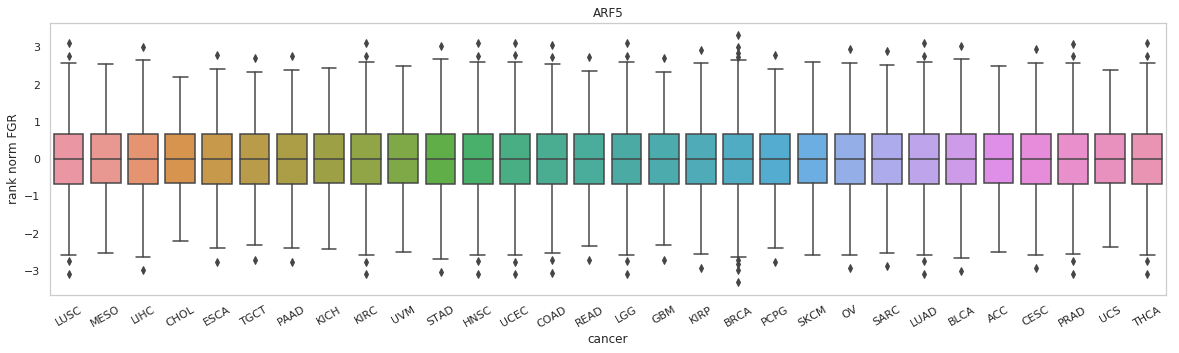

In [39]:
x="ARF5"
#plot rna expression by cancer type
sns.set(style="whitegrid", font_scale = 1)
plt.figure(figsize=(20,5))
sns.set_style("whitegrid", {'axes.grid' : False})
ax = sns.boxplot(x="cancer", y=x, data=compiled)
ax.set(xlabel="cancer", ylabel='rank norm FGR')
plt.xticks(rotation=30)
plt.title(x)

In [40]:
del compiled["cancer"]
compiled["IID"]=compiled["FID"]
cols=["FID","IID"]+compiled.columns.tolist()[1:-1]
compiled=compiled[cols]
compiled.columns=[x.replace("-",".") for x in compiled.columns]
compiled=compiled.fillna(-9)

In [41]:
compiled.to_csv(pheno_dir+"pheno_all_zcancer",index=None,sep="\t")

In [46]:
len(compiled.columns[2:].tolist())

974